In [2]:
from reservoir_rls_multires import *
import matplotlib.pyplot as plt
from lorenz63 import *
from scipy.signal import welch, periodogram, detrend
from sklearn.preprocessing import StandardScaler
import cma

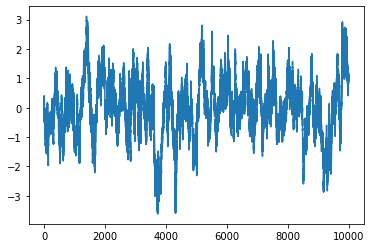

In [14]:
data_length = 1000000
tau = 0.01
step = 0.01
data = ornstein_uhlenbeck_em(data_length, transient_length = 0, tau = tau, sample_tau = step, theta = 0.01,sigma = 1, seed = 7)

SS = StandardScaler()
data = SS.fit_transform(data.reshape(-1,1)).flatten()
plt.plot(np.arange(data.size)*step, data)
plt.show()

In [15]:
data_min = np.min(data)
data_max = np.max(data)
data_scaled = (data - (data_max+data_min)/2)/(data_max-data_min)*(48/28-1)+1+(48/28-1)/2
print(np.min(data_scaled))
print(np.max(data_scaled))

1.0
1.7142857142857144


In [16]:
np.savetxt('ornstein_uhlenbeck_data.csv', data_scaled, delimiter = ',')

(500001,)
(500001,)
[0.0002]
[5000.]


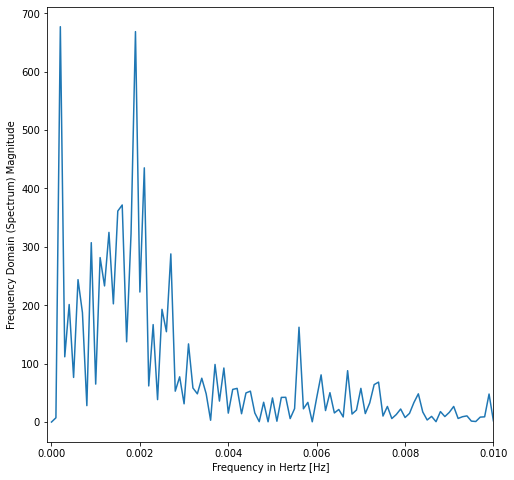

In [17]:
nperseg = 10000000

f_s = 1/step
freqs, X = periodogram(data, f_s, scaling = 'density')
print(X.shape)
print(freqs.shape)
fig, ax = plt.subplots(figsize = (8,8))

ax.plot(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-1e-4, 1e-2)
#ax.set_ylim(0, 1000)

freqsr, Xr = periodogram(data, f_s, scaling = 'density')
top_freq = freqsr[np.abs(Xr) == np.max(np.abs(Xr))]
print(top_freq)
print(1/top_freq)

In [18]:
get_data = True
data_length = 1000000
step = 0.05
f_s = 1/step
if get_data:
    external_data = np.loadtxt('ornstein_uhlenbeck_data.csv', delimiter = ',')
    r_t = lambda x: r_t_extern(x, external_data, tau = 0.01)
    dx_dt = lambda x, time, r_t: dxdt_lorenz(x, time, r_t)
    lorenz_data_ou = getLorenzData(data_length, r_t, dx_dt, sample_tau = step)
    np.savetxt('lorenz_data_ou_step%0.2f.csv' %(step), lorenz_data_ou, delimiter = ',')
else:
    external_data = np.loadtxt('ornstein_uhlenbeck_data.csv', delimiter = ',')
    lorenz_data_ou = np.loadtxt('lorenz_data_ou_step%0.2f.csv' %(step), delimiter = ',')
"""
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111,projection = '3d')
ax.plot3D(lorenz_data_rossler[:,0],lorenz_data_rossler[:,1],lorenz_data_rossler[:,2])
plt.show()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111,projection = '3d')
ax.plot3D(lorenz_data_rossler[:,3],lorenz_data_rossler[:,4],lorenz_data_rossler[:,5])
plt.show()

init_delay = 10000
scaled_data = lorenz_data_rossler[init_delay:,:3]
scaled_data = np.ascontiguousarray(scaled_data)
SS = StandardScaler()

scaled_data_external = SS.fit_transform(lorenz_data_rossler[:,4].reshape(-1,1))
data_external = lorenz_data_rossler[:,4]

Wn_xy = 0.0075
Wn_z = Wn_xy
lorenz_data_split = separate_lorenz_2scale(lorenz_data_rossler[:,:3], f_s, Wn_xy, Wn_z, filter_order = 10)
data_external = lorenz_data_split[init_delay:,5]
lorenz_data_rossler  = lorenz_data_rossler[init_delay:]
scaled_data_external = SS.fit_transform(data_external.reshape(-1,1))
plt.plot(lorenz_data_rossler[:,4])
plt.plot(data_external-np.mean(data_external))
plt.show()
"""

"\nfig = plt.figure(figsize = (8,8))\nax = fig.add_subplot(111,projection = '3d')\nax.plot3D(lorenz_data_rossler[:,0],lorenz_data_rossler[:,1],lorenz_data_rossler[:,2])\nplt.show()\nfig = plt.figure(figsize = (8,8))\nax = fig.add_subplot(111,projection = '3d')\nax.plot3D(lorenz_data_rossler[:,3],lorenz_data_rossler[:,4],lorenz_data_rossler[:,5])\nplt.show()\n\ninit_delay = 10000\nscaled_data = lorenz_data_rossler[init_delay:,:3]\nscaled_data = np.ascontiguousarray(scaled_data)\nSS = StandardScaler()\n\nscaled_data_external = SS.fit_transform(lorenz_data_rossler[:,4].reshape(-1,1))\ndata_external = lorenz_data_rossler[:,4]\n\nWn_xy = 0.0075\nWn_z = Wn_xy\nlorenz_data_split = separate_lorenz_2scale(lorenz_data_rossler[:,:3], f_s, Wn_xy, Wn_z, filter_order = 10)\ndata_external = lorenz_data_split[init_delay:,5]\nlorenz_data_rossler  = lorenz_data_rossler[init_delay:]\nscaled_data_external = SS.fit_transform(data_external.reshape(-1,1))\nplt.plot(lorenz_data_rossler[:,4])\nplt.plot(data_ex

In [19]:
def phase_min_func(delay, truth, filtered):
    delay = round(delay)
    truth_delayed = truth[:truth.shape[0]-delay]
    filtered_delayed = filtered[delay:]
    val = -np.mean(truth_delayed * filtered_delayed)
    return val
def min_func_wphase(x, mask, base_data, f_s, true_external_data,\
    base_res, num_tests, num_nodes, pred_length, train_lenght, scale = True, 
    external_output = True):
    init_delay = 20000
    max_freq = 0.15
    min_freq = 0.001
    Wn_xy = x[0]/10*(max_freq-min_freq)+min_freq
    Wn_z = Wn_xy
    data_split = separate_lorenz_2scale(base_data, f_s, Wn_xy, Wn_z, filter_order = 10)
    base_external_data = data_split[init_delay:,-1]
    num_delays = 10000
    z_centered = base_external_data - np.mean(base_external_data)
    min_func   = lambda delay: phase_min_func(delay, true_external_data[init_delay:], z_centered)
    func_vals = np.zeros(num_delays)
    for i in range(num_delays):
        func_vals[i] = min_func(i)
    min_delay = np.argmin(func_vals)
    data = base_data[init_delay:base_data.shape[0]-min_delay]
    external_data = base_external_data[min_delay:]
    if scale:
        SS = StandardScaler()
        external_data = SS.fit_transform(external_data.reshape(-1,1))
    funval = vt_min_function_norm_external(data,external_data, x[1:], mask, base_res.Win, base_res.A, \
        num_tests = num_tests,  num_nodes = num_nodes, pred_length = pred_length, train_length = train_length,\
        external_output = external_output)
    return funval
def min_func_wtruth(x, mask, base_data, f_s, true_external_data,\
    base_res, num_tests, num_nodes, pred_length, train_length, scale = True, 
    external_output = True):
    init_delay = 0
    data = base_data[init_delay:]
    external_data = true_external_data[init_delay:]
    if scale:
        SS = StandardScaler()
        external_data = SS.fit_transform(external_data.reshape(-1,1))
    funval = vt_min_function_norm_external(data,external_data, x, mask, base_res.Win, base_res.A, \
        num_tests = num_tests,  num_nodes = num_nodes, pred_length = pred_length, train_length = train_length,\
        external_output = external_output)
    return funval
num_nodes = 360
num_tests = 200
train_length = 3000
sync_length = 500
pred_length = 500
res_seed = 1
base_res = reservoir(4,num_nodes,input_weight = 1, spectral_radius = 1, seed = res_seed) #Generate a reservoir
mask = ['input_weight', 'regularization', 'leakage', 'forget']
x0 = np.array([6,4,0,9])
min_func_base = lambda x: min_func_wtruth(x, mask, np.ascontiguousarray(lorenz_data_ou), f_s, external_data,\
    base_res, num_tests, num_nodes, pred_length, train_length)
sigma = 2

In [20]:
opts = cma.CMAOptions()
opts.set('popsize',10*x0.size) # Set number of samples per generation
"""
Set bounds on parameters. IMPORTANT: The mean returned by cma-es is
the mean BEFORE the boundary function is applied, so the mean may not
lie in the domain set by bounds. To obtain the true sample mean requires 
downloading the cma-es package from github and editing one of the 
functions. Ask me if you need to do this.
"""
opts.set('bounds', [0,10]) 
opts.set('seed', 5) # Seed for the initial samples
"""
File where results are saved. IMPORTANT: Full covariance matrix is 
NOT saved, nor are the exact samples. If these need to be saved, one
will also have to download from github and make some edits. Again,
ask me.
"""
opts.set('verb_filenameprefix','cmaes_lorenz_ou_wexternout_scaled_res%d\\' % res_seed)
results = cma.fmin(min_func_base, x0, sigma, options = opts) # Run the algorithm

(20_w,40)-aCMA-ES (mu_w=11.3,w_1=16%) in dimension 4 (seed=5, Tue Jan 26 10:50:53 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     40 -1.350000000000000e+01 1.0e+00 1.91e+00  2e+00  2e+00 18:38.9
    2     80 -1.400000000000000e+01 1.4e+00 1.79e+00  1e+00  2e+00 37:33.9
    3    120 -1.500000000000000e+01 1.6e+00 1.59e+00  7e-01  1e+00 62:52.7


KeyboardInterrupt: 